# todo:

- Determine genes that accumulate mutations

- normalize to fibendo mutation rate and calculate delta increase for tumors
    - because of differences in expression, this may not be a good idea using the cosmic filter
- look for broadly highly mutated genes

# Setup

In [94]:
# base
import pandas as pd
from pandas.api.types import CategoricalDtype, is_categorical_dtype
import numpy as np
from scipy import sparse, stats
from scipy.stats import ttest_ind, ranksums, variation, pearsonr
import warnings
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression, LinearRegression, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn import preprocessing
from sklearn.metrics import f1_score, roc_auc_score, jaccard_similarity_score
from sklearn.mixture import GaussianMixture
import math
from IPython.core.display import HTML
import numpy.ma as ma # masking package
import statsmodels.api as sm
import random
import subprocess, os, sys, mygene, string, glob
import pickle
import tqdm
from itertools import combinations, permutations
import s3fs
import boto3

#plotting
from plotnine import *
import plotnine
import matplotlib as mp

warnings.filterwarnings('ignore')

def symbol2field(genelist, field='summary',species='human'):
    # wrapper around mygene query
    # genelist = list of str gene symbols
    mg = mygene.MyGeneInfo()
    xli = genelist
    out = mg.querymany(xli, scopes='symbol', fields='summary', species=species)
    return out


In [2]:
fibroraw = pd.read_csv('s3://daniel.le-work/test/fibro_rawdata.csv', index_col = 0).T
fibroraw.head()


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A10_B001474,0,0,0,932,0,0,0,0,0,0,...,0,0,0,0,0,0,221,0,0,0
A10_B002572,0,0,0,1550,0,0,0,0,33,0,...,0,0,0,0,81,0,15,135,92,335
A10_B003070,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,37,58,186
A10_B003071,0,0,0,1735,0,0,0,0,14,0,...,0,0,0,0,0,0,0,102,0,0
A10_B003115,0,0,0,1503,0,0,0,0,0,0,...,0,0,0,0,0,0,0,16,0,0


In [3]:
endoraw = pd.read_csv('s3://daniel.le-work/test/endo_rawdata.csv', index_col = 0).T
endoraw.head()


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A10_B001548,0,0,0,7263,0,0,0,0,269,0,...,0,0,0,0,0,0,0,261,0,0
A10_B001554,0,0,0,1520,0,0,0,0,0,0,...,0,0,0,0,0,0,0,368,0,0
A10_B001558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A11_B001551,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
A11_B001554,0,0,0,3226,14,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
muts = pd.read_csv('s3://daniel.le-work/test/geneCellMutationCounts_5.1.19.csv', index_col = 0)
muts.head()


,EGFR,GTF2IRD1,HLA-B,HLA-H,APOL3,RPS16,CRTAM,SMPDL3B,HSP90B1,FUZ,...,SYT13,LRRC73,ICAM5,TNFAIP8L3,ELANE,CHD5,IRF5,EPB41L4B,C15orf40,ATP1A3
cellName,,,,,,,,,,,,,,,,,,,,,
A10_1001000407,32,3,6,2,2,3,2,2,1,1,...,0,0,0,0,0,0,0,0,0,0
A10_1001000408,0,1,5,0,2,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
A10_1001000412,38,0,6,0,0,3,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
A10_B000863,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10_B001007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
metadf = pd.read_csv('s3://daniel.le-work/test/all_epi_metadata.csv', index_col = 0).loc[:, ['analysis','inferCNV_annotation']]
metadf['type_treatment'] = [f'{x}_{y}'  for x,y in zip(metadf['analysis'],metadf['inferCNV_annotation'])]

display(metadf.head())
groupby = list(set(metadf.type_treatment))
display(groupby)


,analysis,inferCNV_annotation,type_treatment
A10_1001000407,grouped_pd,tumor,grouped_pd_tumor
A10_B000863,grouped_pd,nontumor,grouped_pd_nontumor
A11_B000860,grouped_pd,nontumor,grouped_pd_nontumor
A12_B003103,grouped_pd,nontumor,grouped_pd_nontumor
A15_B000420,naive,nontumor,naive_nontumor


['grouped_pd_nontumor',
 'grouped_pr_nontumor',
 'naive_tumor',
 'naive_nontumor',
 'grouped_pr_tumor',
 'grouped_pd_tumor']

In [6]:
epiraw = pd.read_csv('s3://daniel.le-work/test/all_epi_rawdata.csv', index_col = 0).T
epiraw.head()


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
A10_1001000407,0,0,0,0,0,0,0,0,52,0,...,0,0,0,0,0,0,0,3,0,0
A10_B000863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A11_B000860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A12_B003103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A15_B000420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# First pass

In [ ]:
tum_muts = muts[[x in metadf[metadf.inferCNV_annotation == 'tumor'].index.tolist() for x in muts.index]]
norm_muts = muts[[x in metadf[metadf.inferCNV_annotation == 'nontumor'].index.tolist() for x in muts.index]]
fib_muts = muts[[x in fibroraw.index.tolist() for x in muts.index]]
endo_muts = muts[[x in endoraw.index.tolist() for x in muts.index]]

tum_counts = epiraw[[x in metadf[metadf.inferCNV_annotation == 'tumor'].index.tolist() for x in epiraw.index]]
norm_counts = epiraw[[x in metadf[metadf.inferCNV_annotation == 'nontumor'].index.tolist() for x in epiraw.index]]
fib_counts = fibroraw
endo_counts = endo_muts

In [ ]:
variants_df = pd.merge(tum_muts.mean().reset_index().rename(columns = {0:'tumor_mut_mean'}),
             norm_muts.mean().reset_index().rename(columns = {0:'nontumor_mut_mean'}),
             'inner',
             'index')
variants_df = pd.merge(variants_df,
                       fib_muts.mean().reset_index().rename(columns = {0:'fib_mut_mean'}),
                       'inner',
                       'index')

counts_df = pd.merge(tum_counts.mean().reset_index().rename(columns = {0:'tumor_count_mean'}),
             norm_counts.mean().reset_index().rename(columns = {0:'nontumor_count_mean'}),
             'inner',
             'index')
counts_df = pd.merge(counts_df,
                     fib_counts.mean().reset_index().rename(columns = {0:'fib_count_mean'}),
                     'inner',
                     'index')

merge_df = pd.merge(variants_df, 
                    counts_df, 
                    'inner',
                    'index')
merge_df.head()


In [ ]:
merge_melt = (pd.melt(merge_df, 
                      id_vars=['index',
                               'tumor_mut_mean',
                               'nontumor_mut_mean',
                               'fib_mut_mean'])
              .rename(columns = {'value':'reads',
                                 'variable':'reads_group'})
             )
merge_melt['reads_group'] = [x.split('_')[0] for x in merge_melt['reads_group']]

merge_melt = (pd.melt(merge_melt, 
                      id_vars=['index',
                               'reads_group',
                               'reads',])
              .rename(columns = {'value':'muts',
                                 'variable':'muts_group'})
             )
merge_melt['muts_group'] = [x.split('_')[0] for x in merge_melt['muts_group']]
merge_melt = merge_melt[[x == y for x,y in zip(merge_melt.reads_group, merge_melt.muts_group)]]
merge_melt['norm_muts'] = merge_melt.muts / merge_melt.reads
merge_melt['log_norm_muts'] = np.log10(merge_melt['norm_muts'])
merge_melt['log_muts'] = np.log10(merge_melt['muts'])
merge_melt['log_reads'] = np.log10(merge_melt['reads'])
merge_melt = merge_melt.replace([np.inf, -np.inf], np.nan).dropna()

top_genes = (merge_melt[merge_melt.reads_group == 'tumor']
             .sort_values('norm_muts', ascending=False)
             .assign(rank_norm_muts = lambda df: df.norm_muts.rank(pct = True))
             .query('rank_norm_muts > 0.9')
            )['index'].tolist()
merge_melt['label'] = [x in top_genes for x in merge_melt['index']]


In [ ]:
refx = 'log_reads'
refy = 'log_muts'

plotnine.options.figure_size = (10,10)
print(ggplot(merge_melt)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_point(aes(refx,refy, color = 'reads_group'), alpha = 0.025)
#       + stat_smooth(aes(refx,refy), method = 'lm')
#       + scale_x_log10()
#       + scale_y_log10()
      + facet_wrap('~reads_group')
     )


In [ ]:
refy = 'log_muts'

plotnine.options.figure_size = (10,10)
print(ggplot(merge_melt)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_density(aes(refy, fill = 'reads_group', color = 'reads_group'), alpha = 0.1)
      + facet_wrap('~reads_group')
     )
        

In [ ]:
refy = 'log_norm_muts'

plotnine.options.figure_size = (10,10)
print(ggplot(merge_melt)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_density(aes(refy, fill = 'reads_group', color = 'reads_group'), alpha = 0.1)
      + facet_wrap('~reads_group')
     )

# Second pass

In [7]:
# compile groups
groupby = list(set(metadf.type_treatment))
master_counts = pd.DataFrame()
for group in tqdm.tqdm(groupby):
    muts_slice = (muts[[x in metadf[metadf.type_treatment == group]
                        .index.tolist() for x in muts.index]]
                  .mean()
                  .reset_index()
                  .rename(columns = {0:'muts'}))
    epi_slice = (epiraw[[x in metadf[metadf.type_treatment == group]
                         .index.tolist() for x in epiraw.index]]
                  .mean()
                  .reset_index()
                  .rename(columns = {0:'reads'}))
    group_slice = pd.merge(muts_slice, epi_slice, 'inner', 'index')
    group_slice['type_treatment'] = group
    master_counts = master_counts.append(group_slice)

# add fibroblast control
fib_muts = (muts[[x in fibroraw.index.tolist()+endoraw.index.tolist() for x in muts.index]]
                .mean()
                .reset_index()
                .rename(columns = {0:'muts'}))
fib_counts = (fibroraw.append(endoraw)
              .mean()
              .reset_index()
              .rename(columns = {0:'reads'}))
fib_merge = pd.merge(fib_muts, fib_counts, 'inner', 'index')
fib_merge['type_treatment'] = 'fibendo_control'
master_counts = master_counts.append(fib_merge)

# transfroms
master_counts['norm_muts'] = master_counts.muts / master_counts.reads
master_counts['log_norm_muts'] = np.log10(master_counts['norm_muts'])
master_counts['log_muts'] = np.log10(master_counts['muts'])
master_counts['log_reads'] = np.log10(master_counts['reads'])
master_counts = master_counts.replace([np.inf, -np.inf], np.nan)
master_counts['type'] = [x.split('_')[-1] for x in master_counts['type_treatment']]
master_counts['treatment'] = [x.split(f'_{y}')[0] for x,y in zip(master_counts['type_treatment'],master_counts['type']) ]
master_counts = master_counts.sort_values('index')

master_counts.head()



100%|██████████| 6/6 [01:03<00:00, 10.87s/it]


,index,muts,reads,type_treatment,norm_muts,log_norm_muts,log_muts,log_reads,type,treatment
12762,A1BG,0.0,3.874398,grouped_pd_tumor,0.0,NaN,NaN,0.588204,tumor,grouped_pd
12762,A1BG,0.0,17.086420,grouped_pd_nontumor,0.0,NaN,NaN,1.232651,nontumor,grouped_pd
12762,A1BG,0.0,4.188540,naive_nontumor,0.0,NaN,NaN,0.622063,nontumor,naive
12762,A1BG,0.0,2.368932,grouped_pr_tumor,0.0,NaN,NaN,0.374553,tumor,grouped_pr
12762,A1BG,0.0,17.305666,fibendo_control,0.0,NaN,NaN,1.238188,control,fibendo


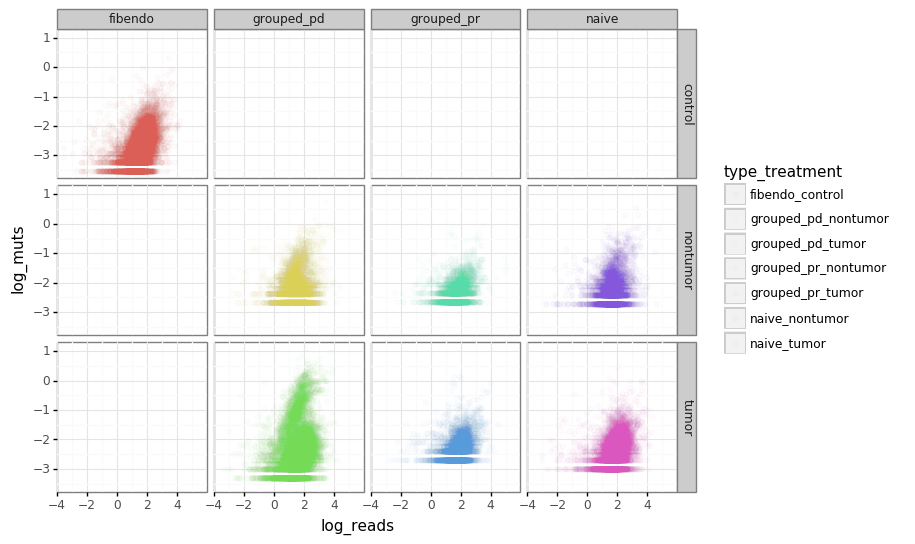

<ggplot: (-9223363255522849557)>


In [8]:
refx = 'log_reads'
refy = 'log_muts'

plotnine.options.figure_size = (8,8)
print(ggplot(master_counts)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + theme(aspect_ratio = 1)
      + geom_point(aes(refx,refy, color = 'type_treatment'), alpha = 0.025)
      + facet_grid('type~treatment')
     )

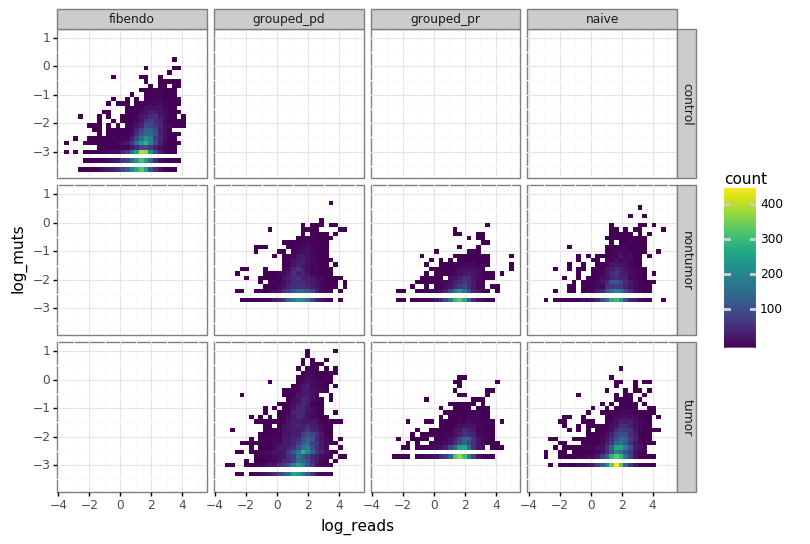

<ggplot: (-9223363255526817248)>


In [9]:
refx = 'log_reads'
refy = 'log_muts'

plotnine.options.figure_size = (8,8)
print(ggplot(master_counts)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + theme(aspect_ratio = 1)
      + geom_bin2d(aes(refx,refy))
      + facet_grid('type~treatment')
     )

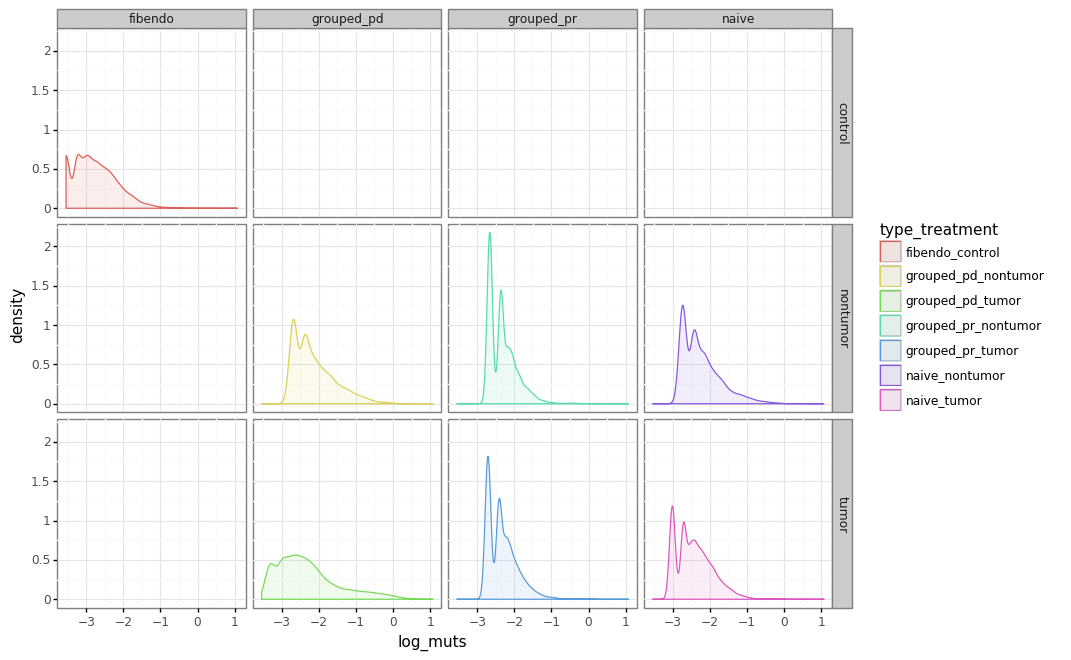

<ggplot: (-9223363255525831764)>


In [10]:
refy = 'log_muts'

plotnine.options.figure_size = (10,10)
print(ggplot(master_counts)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_density(aes(refy, fill = 'type_treatment', color = 'type_treatment'), alpha = 0.1)
      + facet_grid('type~treatment')
     )


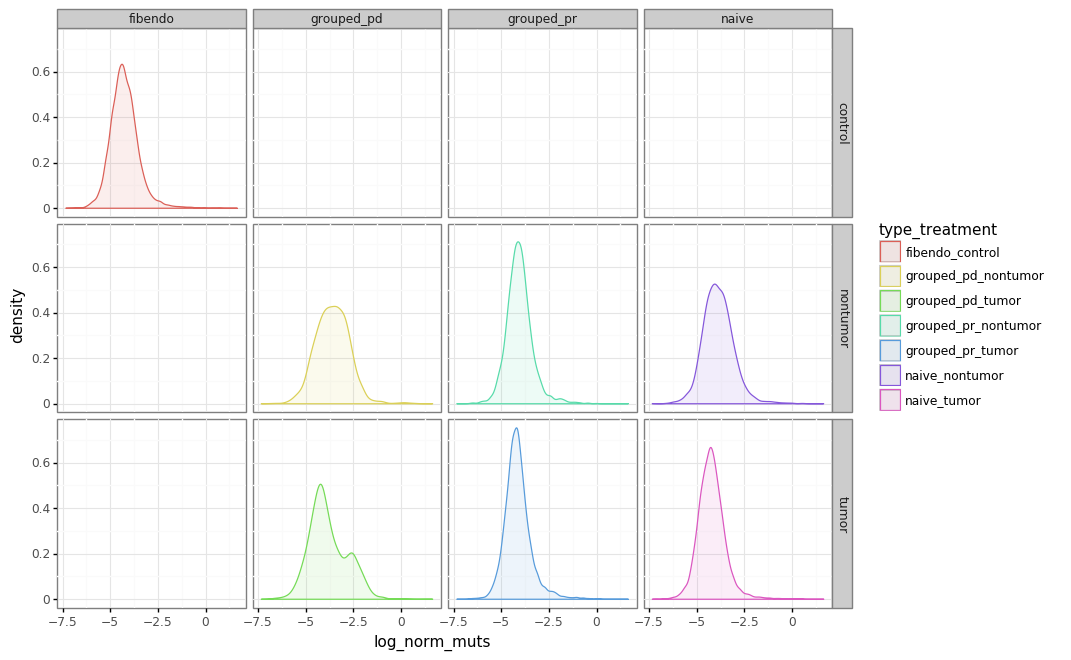

<ggplot: (-9223363255526821383)>


In [11]:
refy = 'log_norm_muts'

plotnine.options.figure_size = (10,10)
print(ggplot(master_counts)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_density(aes(refy, fill = 'type_treatment', color = 'type_treatment'), alpha = 0.1)
      + facet_grid('type~treatment')
     )


In [11]:
# summarise gene-wise mutation burden
master_counts['muts_reads'] = master_counts['muts'] / master_counts['reads']
summ_df = pd.DataFrame(master_counts.groupby(['type_treatment','index'])['muts_reads'].median()).reset_index()


In [12]:
summ_df.head()

,type_treatment,index,muts_reads
0,fibendo_control,A1BG,0.000000
1,fibendo_control,A1CF,0.000000
2,fibendo_control,A2M,0.000012
3,fibendo_control,A2ML1,0.000000
4,fibendo_control,A4GALT,0.000500


# Clustering
- K-means fails

## 1D GMM

In [ ]:
input_df = (master_counts[master_counts.type_treatment == 'grouped_pd_tumor']
           .dropna())
X = input_df.loc[:,['log_norm_muts']].as_matrix()


In [ ]:
gmm = GaussianMixture(n_components = 2)
gmm = gmm.fit(X=X)

gmm_x = np.linspace(-8,3,100)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

mu1 = gmm.means_[0,0]
mu2 = gmm.means_[1,0]
sigma1 = gmm.covariances_[0,0]
sigma2 = gmm.covariances_[1,0]

gmm_df = pd.DataFrame({'gmm_x':gmm_x,
                       'gmm_y':gmm_y})


In [ ]:
plotnine.options.figure_size = (3,3)
print(ggplot(gmm_df)
      + theme_bw()
      + geom_point(aes('gmm_x','gmm_y'))
      + geom_vline(aes(xintercept = mu1), color = 'red', linetype = ':')
      + geom_vline(aes(xintercept = mu2), color = 'red', linetype = ':')
      + geom_vline(aes(xintercept = np.mean([mu1, mu2])), color = 'blue', linetype = '--')
     )

In [ ]:
input_df['pass'] = input_df['log_norm_muts'] > mu1

refx = 'log_reads'
refy = 'log_muts'

# highlight gene of interest
GOI = 'TP53'
label_df = input_df[input_df['index'] == GOI]

plotnine.options.figure_size = (3,3)
print(ggplot(input_df)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + theme(aspect_ratio = 1)
      + geom_point(aes(refx,refy,color = 'pass'), alpha = 0.025)
      + geom_point(label_df, aes(refx,refy), shape = 'x')
     )


In [ ]:
input_df[input_df['pass'] == True].sort_values('log_muts').head(50)

## Density-Based Spatial Clustering of Applications with Noise (DBSCAN) 

In [ ]:
from sklearn.cluster import DBSCAN


In [ ]:
input_df = master_counts[master_counts.type_treatment == 'grouped_pd_tumor']
X = input_df.loc[:,['log_reads', 'log_muts']].as_matrix()


In [ ]:
clustering = DBSCAN(eps=0.1, min_samples=50).fit(X)
input_df['label'] = clustering.labels_

refx = 'log_reads'
refy = 'log_muts'
label = 'label'

plotnine.options.figure_size = (3,3)
print(ggplot(input_df)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + theme(aspect_ratio = 1)
      + geom_point(aes(refx,refy,color = label))
     )


# Linear regression

In [ ]:
set(master_counts.type_treatment)

In [ ]:
ref = 'fibendo_control'
groubys = [x for x in set(master_counts.type_treatment) if x != ref]

for groupby in groubys:
    print(groupby)
    input_df = master_counts
    xvar = (input_df[input_df.type_treatment == ref]
            .loc[:, ['log_norm_muts','index']]
            .rename(columns = {'log_norm_muts':ref}))
    yvar = (input_df[input_df.type_treatment == groupby]
            .loc[:, ['log_norm_muts','index']]
            .rename(columns = {'log_norm_muts':groupby}))
    working_df = pd.merge(xvar, yvar, 'inner', 'index')
    
    plotnine.options.figure_size = (3,3)
    print(ggplot(working_df)
          + theme_bw()
          + geom_bin2d(aes(ref,groupby))
         )


In [ ]:
refy = 'grouped_pd_tumor'
refx = 'fibendo_control'
GOI = 'EGFR'

input_df = master_counts
xvar = (input_df[input_df.type_treatment == refx]
        .loc[:, ['log_norm_muts','index']]
        .rename(columns = {'log_norm_muts':refx}))
yvar = (input_df[input_df.type_treatment == refy]
        .loc[:, ['log_norm_muts','index']]
        .rename(columns = {'log_norm_muts':refy}))
working_df = pd.merge(xvar, yvar, 'inner', 'index').dropna()
label_df = working_df[working_df['index'] == GOI]

X = (working_df
     .loc[:,[refx,refy]]
     .as_matrix())

# clustering
# kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
# working_df['label'] = kmeans.labels_

# huber loss linear regression
huber = HuberRegressor().fit(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))
working_df['huber_fit'] = huber.predict(X[:,0].reshape(-1,1)).tolist()

# outlier maskings with RANSAC
# from sklearn import linear_model
# lr = linear_model.LinearRegression()
# lr.fit(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))
# ransac = linear_model.RANSACRegressor()
# ransac.fit(X[:,0].reshape(-1,1), X[:,1].reshape(-1,1))
# working_df['ransac_fit'] = ransac.predict(X[:,0].reshape(-1,1)).flatten().tolist()

# residuals
working_df['res'] = working_df[refy] - working_df['huber_fit']
working_df['norm_res'] = working_df['res']/np.std(working_df['res'])

plotnine.options.figure_size = (3,3)
print(ggplot(working_df)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_bin2d(aes(refx,refy))
      + geom_point(label_df, aes(refx,refy), shape = 'x', color = 'red')
      + geom_line(aes(refx,'huber_fit'), color = 'red')
#       + geom_line(aes(refx,'ransac_fit'), color = 'blue')
#       + scale_fill_cmap('bwr', limits = (-np.max(working_df['norm_res']),np.max(working_df['norm_res'])))
     )



In [ ]:
ref_res = 'norm_res'
print(ggplot(working_df)
      + theme_bw()
      + theme(aspect_ratio = 1)
      + geom_density(aes(ref_res))
     )

In [ ]:
X = working_df.loc[:,[ref_res]].as_matrix()

gmm = GaussianMixture(n_components = 2)
gmm = gmm.fit(X=X)

gmm_x = np.linspace(-3,5,100)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

mu1 = gmm.means_[0,0]
mu2 = gmm.means_[1,0]
sigma1 = gmm.covariances_[0,0]
sigma2 = gmm.covariances_[1,0]

gmm_df = pd.DataFrame({'gmm_x':gmm_x,
                       'gmm_y':gmm_y})


plotnine.options.figure_size = (3,3)
print(ggplot(gmm_df)
      + theme_bw()
      + geom_point(aes('gmm_x','gmm_y'))
      + geom_vline(aes(xintercept = mu1), color = 'red', linetype = ':')
      + geom_vline(aes(xintercept = mu2), color = 'red', linetype = ':')
      + geom_vline(aes(xintercept = np.mean([mu1, mu2])), color = 'blue', linetype = '--')
     )


In [ ]:
mu1

In [ ]:
test = working_df[working_df.norm_res > mu1]
test['delta'] = (test[refx] - test[refy])**2
test.sort_values('norm_res', ascending = False)


# Analysis of depth dependence

In [ ]:
input_df.head()

In [ ]:
refx = 'grouped_pd_nontumor'
refy = 'grouped_pd_tumor'
GOI = 'BPIFB1'

input_df = master_counts
xvar = (input_df[input_df.type_treatment == refx]
        .loc[:, ['index','muts','reads']]
        .rename(columns = {'log_norm_muts':refx}))
yvar = (input_df[input_df.type_treatment == refy]
        .loc[:, ['index','muts','reads']]
        .rename(columns = {'log_norm_muts':refy}))
working_df = pd.merge(xvar, yvar, 'inner', 'index').dropna()
working_df['delta_reads'] = np.log10(working_df['reads_x']-working_df['reads_y'])
working_df['delta_muts'] = np.log10(working_df['muts_x']-working_df['muts_y'])

label_df = working_df[working_df['index'] == GOI]

In [ ]:
print(ggplot(working_df)
      + theme_bw()
      + geom_bin2d(aes('delta_reads', 'delta_muts'))
     )

In [ ]:
working_df.corr('spearman')**2

# Cell-wise mutation burden

In [13]:
fib_muts = (muts[[x in fibroraw.index.tolist()+endoraw.index.tolist() for x in muts.index]]
                .mean()
                .reset_index()
                .rename(columns = {0:'muts'}))
fib_counts = (fibroraw.append(endoraw)
              .mean()
              .reset_index()
              .rename(columns = {0:'reads'}))
fib_merge = pd.merge(fib_muts, fib_counts, 'inner', 'index')
fib_merge['type_treatment'] = 'fibendo_control'
master_counts = master_counts.append(fib_merge)


In [17]:
epiraw_matched = (epiraw
                 .append(endoraw)
                 .append(fibroraw)
                 .loc[muts.index,:]
                 .loc[:,muts.columns]
                 .dropna()
                )

muts_matched = (muts
                .loc[epiraw_matched.index,:]
               )

norm_muts_df = muts_matched / epiraw_matched
# norm_muts_df = (pd.DataFrame(norm_muts_df
#                              .replace([-np.inf, np.inf], np.nan)
#                              .mean(axis=1, skipna=True))
#                 .reset_index()
#                 .rename(columns = {'cellName':'index',
#                                    0:'mean_mut_rate'
#                                   })
#                )
# norm_muts_df['log_mean_mut_rate'] = np.log10(norm_muts_df['mean_mut_rate'])
# norm_muts_df = pd.merge(norm_muts_df, metadf.reset_index(), 'left', 'index')
# # add sample + patient info
norm_muts_df = pd.merge(norm_muts_df, 
                         (pd.read_csv('s3://daniel.le-work/test/all_epi_metadata.csv', index_col = 0)
                             .loc[:,['sample_name','patient_id']]
                             .reset_index()),
                         'left', 'index')
# norm_muts_df = norm_muts_df.replace(np.nan, 'fibendo_control')



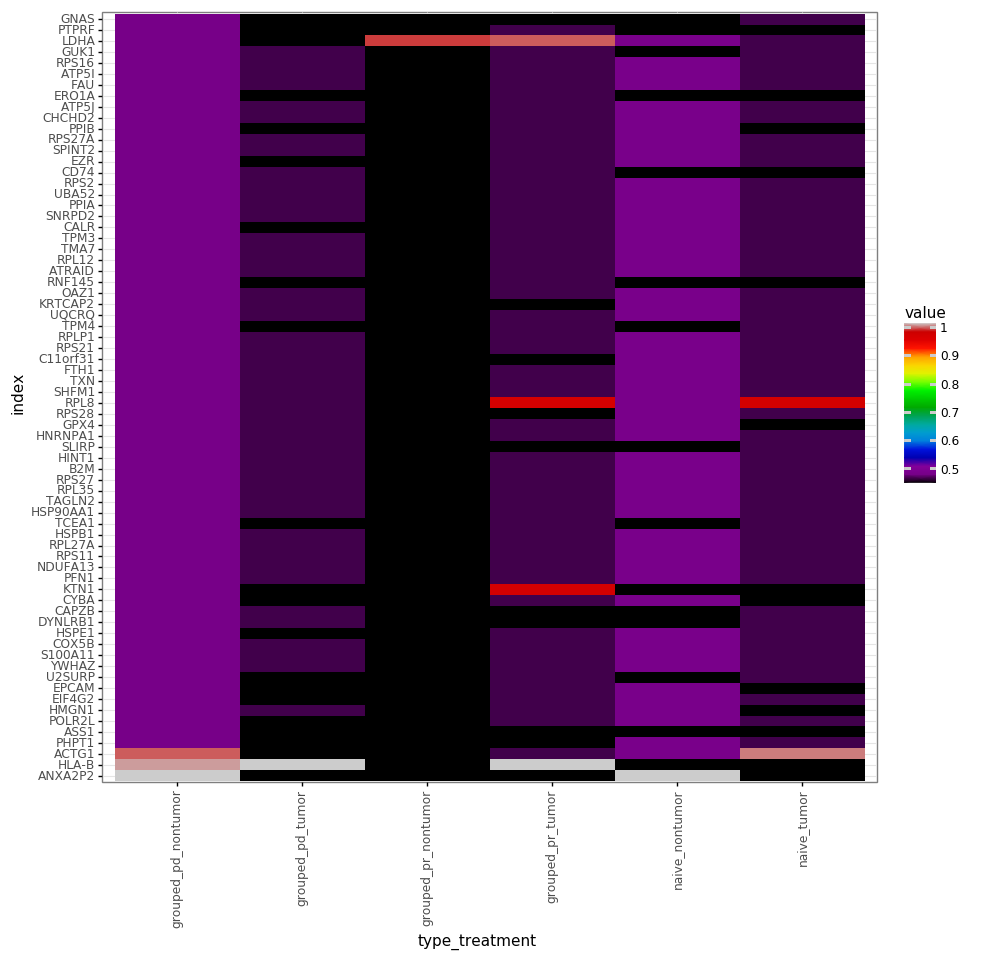

<ggplot: (-9223363251200729298)>


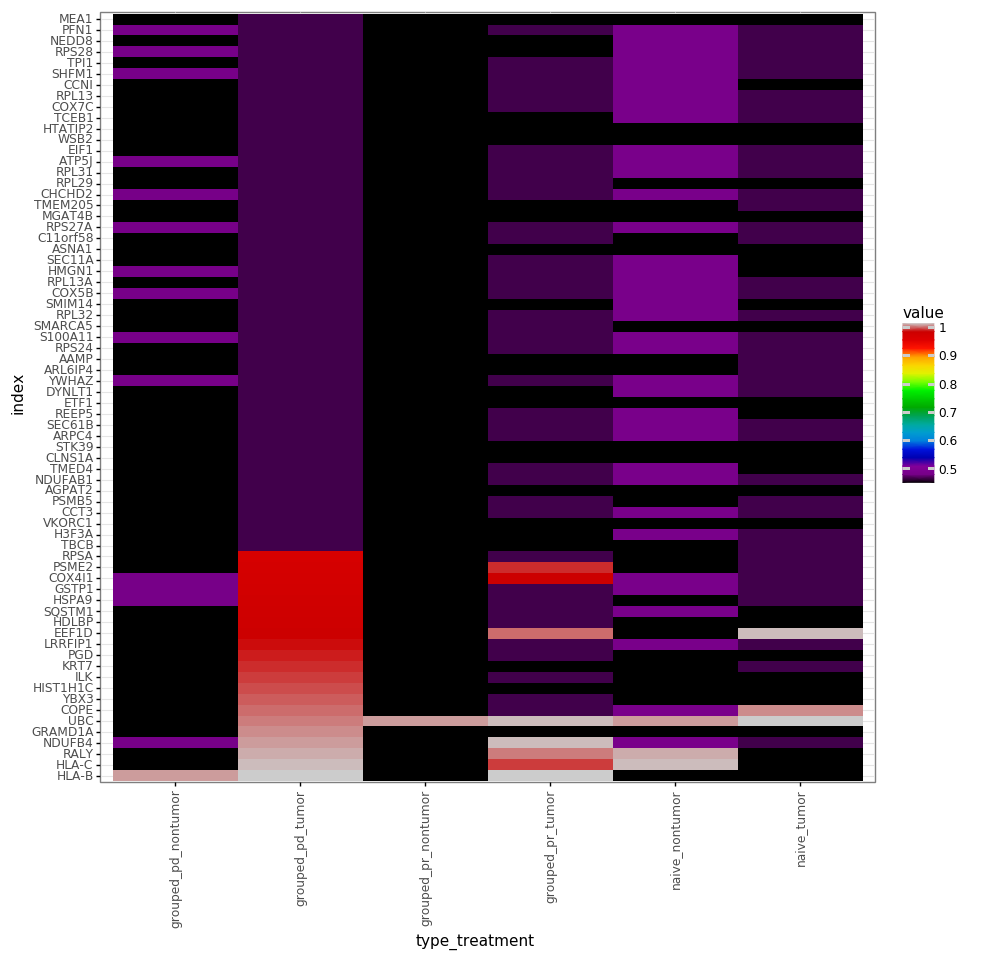

<ggplot: (-9223363251204207819)>


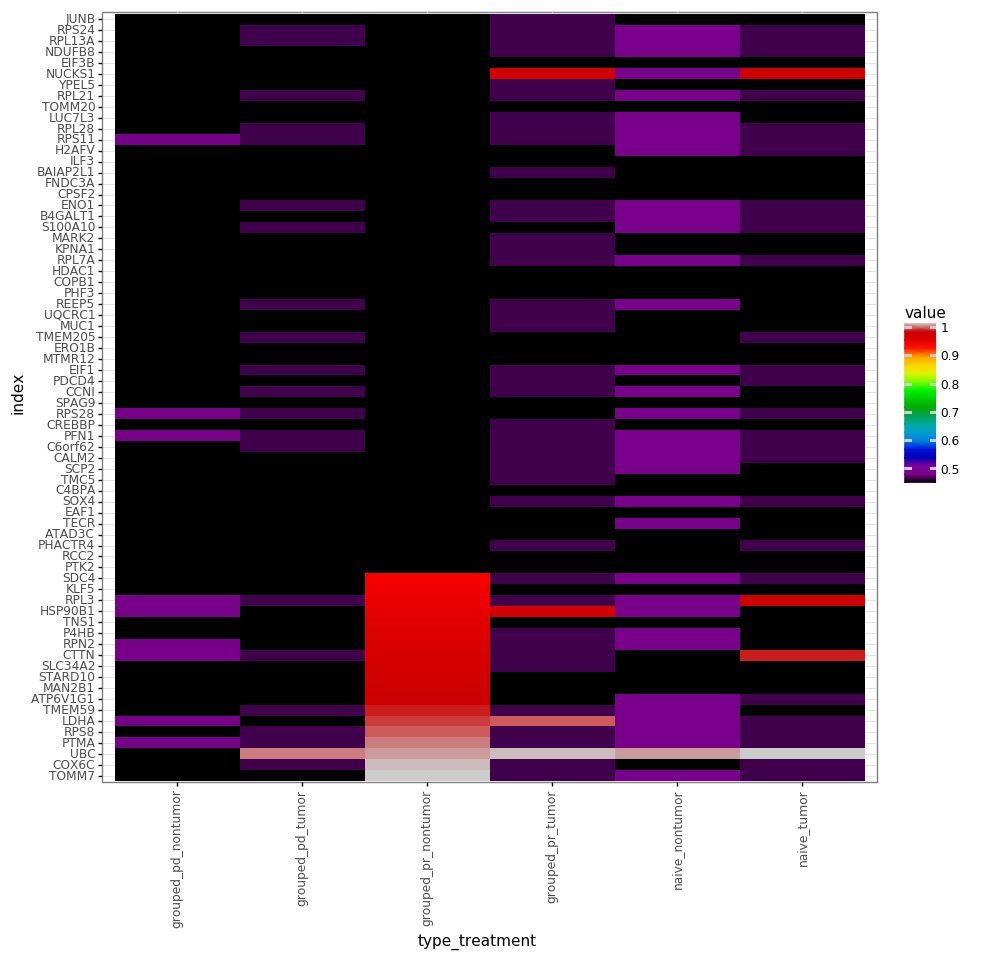

<ggplot: (-9223363250822321818)>


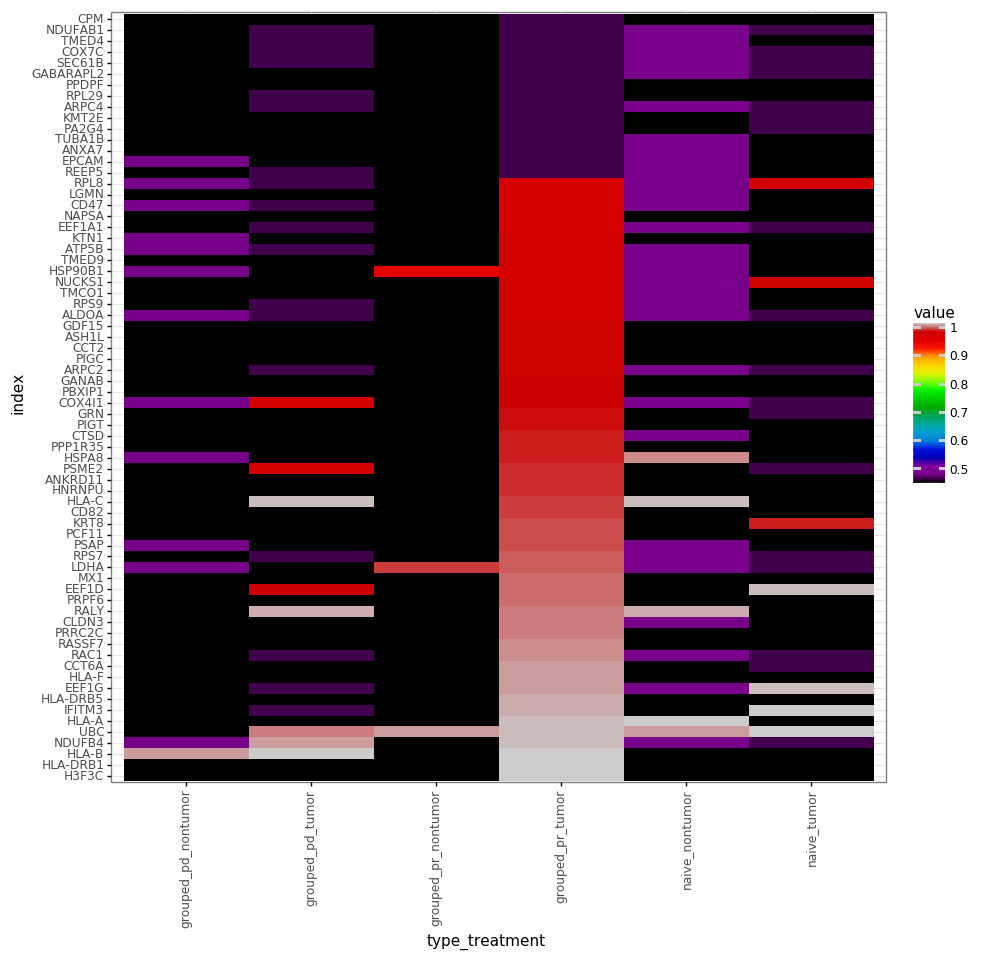

<ggplot: (-9223363250826688203)>


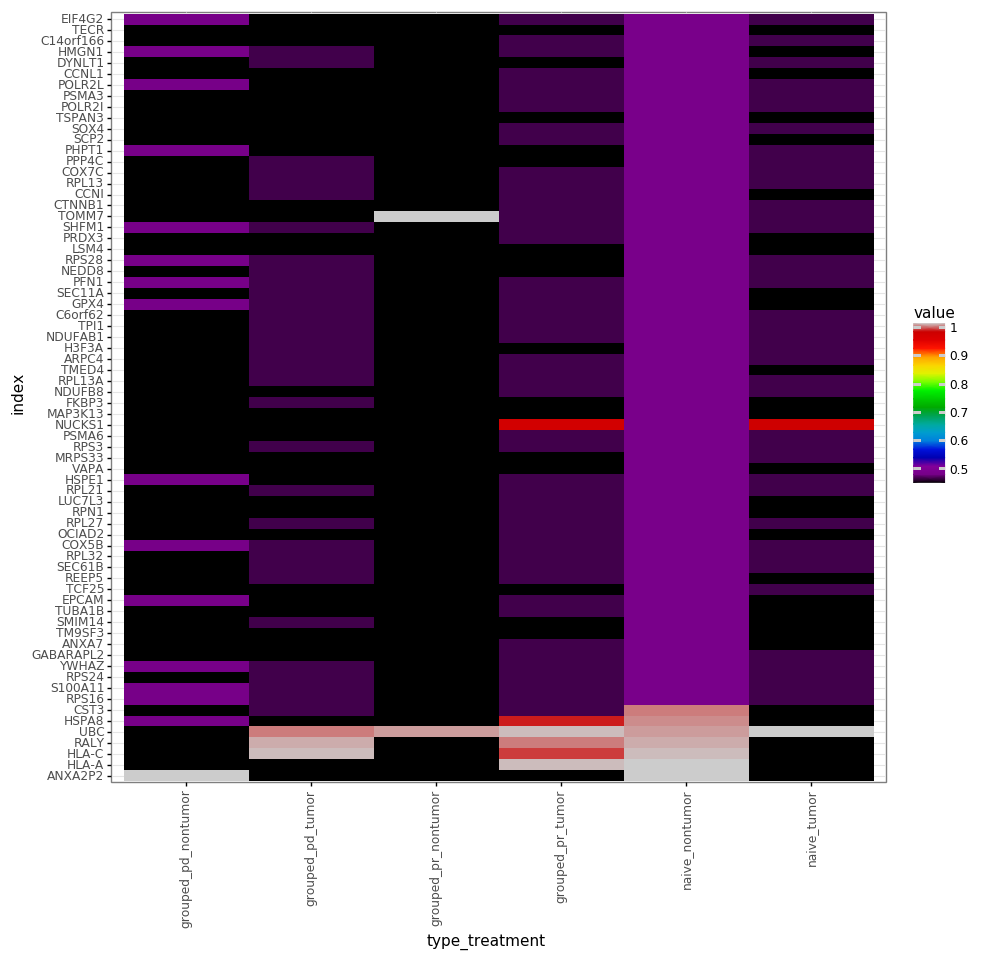

<ggplot: (-9223363251200665877)>


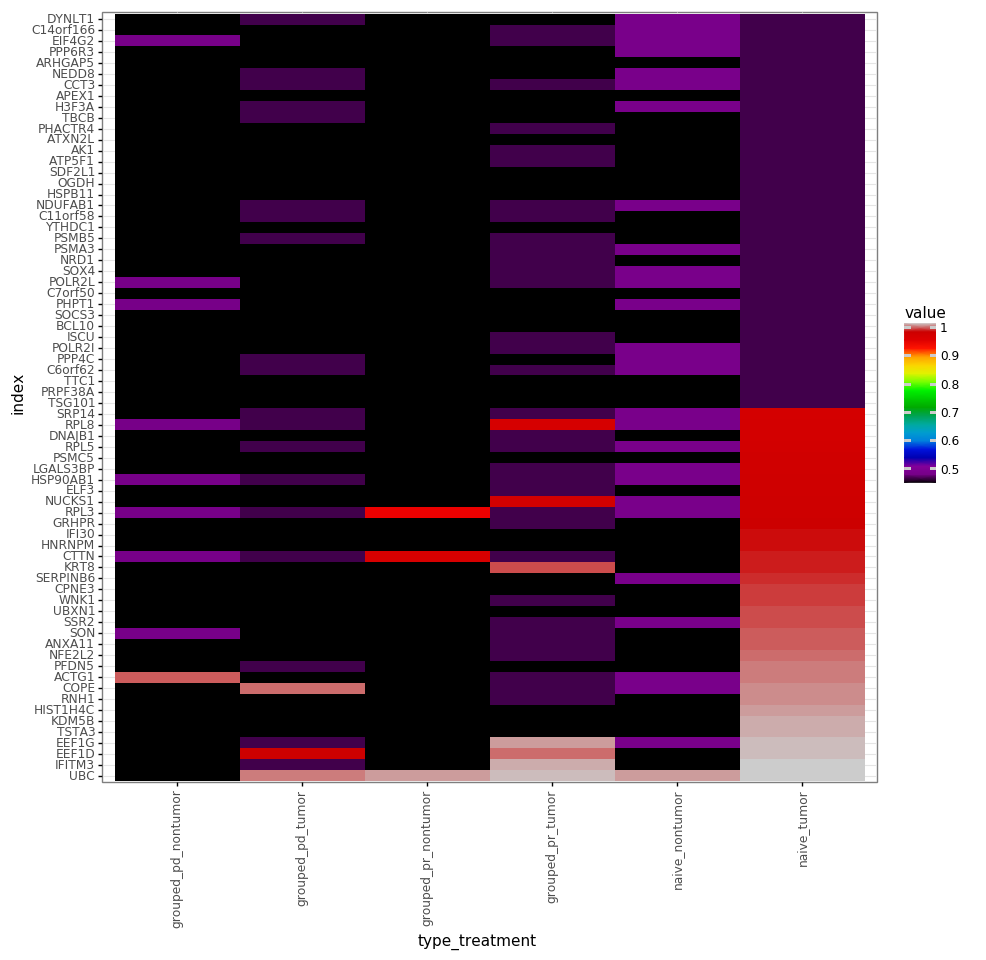

<ggplot: (-9223363250820589596)>


In [370]:
### per-cell and per-gene mutation rate
def custom_mean(df):
    return df.mean(skipna=False)

def custom_median(df):
    return df.median(skipna=False)

gene_n = 70

mut_rate_df = pd.merge(metadf.reset_index().loc[:,['index','type_treatment']],
                 norm_muts_df,
                 'left',
                 'index'
                ).drop(['index', 'patient_id'], axis = 1)
for group in ['grouped_pd_nontumor','grouped_pd_tumor','grouped_pr_nontumor',
              'grouped_pr_tumor','naive_nontumor','naive_tumor']:
    df = (mut_rate_df
         .groupby(['type_treatment','sample_name',])
         .mean()
         .replace(np.inf, np.nan)
         .reset_index()
         .drop('sample_name', axis = 1)
         .groupby('type_treatment')
         .apply(custom_median)
         .T
         .sort_values(group, ascending = False)
        )
    df = df.reset_index()
    index_list = df['index'].tolist()

    # ranked rates
    df = df.rank(pct = True, numeric_only = True)

    df['index'] = index_list
    df['index'] = (df['index']
                   .astype(str)
                   .astype(CategoricalDtype(index_list, ordered=True)))
    df = df.head(gene_n)
    # display(df)
    df_melt = pd.melt(df, id_vars='index')


    plotnine.options.figure_size = (10,10)
    plot = (ggplot(df_melt)
            + theme_bw()
            + theme(axis_text_x = element_text(angle = 90))
            + geom_tile(aes('type_treatment','index',fill = 'value'))
            + scale_fill_cmap(name = 'nipy_spectral', na_value = 'white')
           )

    print(plot)


In [372]:
df = (mut_rate_df
     .groupby(['type_treatment','sample_name',])
     .mean()
     .replace(np.inf, np.nan)
     .reset_index()
     .drop('sample_name', axis = 1)
     .groupby('type_treatment')
     .apply(custom_median)
     .T
     .sort_values(group, ascending = False)
    )
df = df.reset_index()
index_list = df['index'].tolist()

# ranked rates
df = df.rank(pct = True, numeric_only = True)

df['index'] = index_list
df['index'] = (df['index']
               .astype(str)
               .astype(CategoricalDtype(index_list, ordered=True)))
df_melt = pd.melt(df, id_vars='index')


In [412]:
epiraw_matched.head()

,EGFR,GTF2IRD1,HLA-B,HLA-H,APOL3,RPS16,CRTAM,SMPDL3B,HSP90B1,FUZ,...,SYT13,LRRC73,ICAM5,TNFAIP8L3,ELANE,CHD5,IRF5,EPB41L4B,C15orf40,ATP1A3
cellName,,,,,,,,,,,,,,,,,,,,,
A10_1001000407,30.0,128.0,1428.0,61.0,265.0,615.0,117.0,370.0,433.0,60.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10_1001000408,0.0,29.0,1698.0,83.0,49.0,354.0,0.0,5.0,697.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17.0,20.0,3.0,0.0
A10_1001000412,80.0,0.0,2165.0,56.0,0.0,712.0,0.0,98.0,1177.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.0,1.0,58.0,0.0
A10_B000863,0.0,0.0,3289.0,1.0,0.0,95.0,0.0,0.0,575.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10_B001470,41.0,0.0,527.0,3.0,0.0,71.0,0.0,0.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


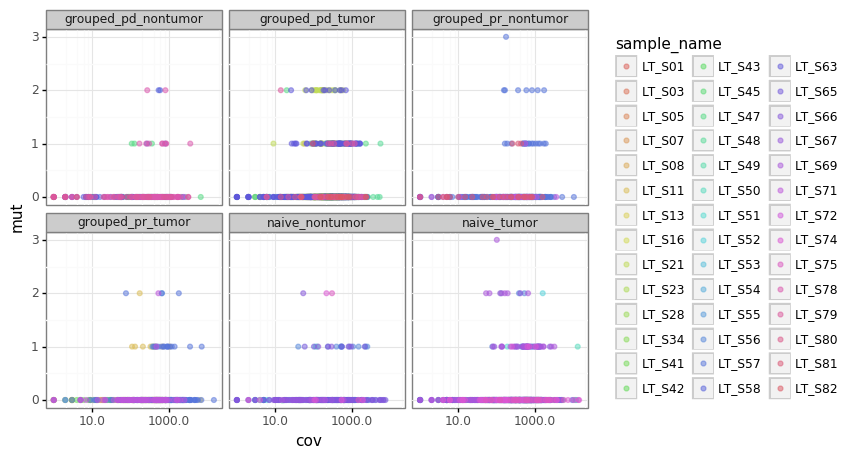

<ggplot: (-9223363250816166919)>
querying 1-1...done.
Finished.
0:  RALY 
 This gene encodes a member of the heterogeneous nuclear ribonucleoprotein (hnRNP) gene family. This protein may play a role in pre-mRNA splicing and in embryonic development. Alternate splicing results in multiple transcript variants. [provided by RefSeq, Sep 2011].


In [470]:
# determine what each cell is doing for a given gene
gene = 'RALY'

# epiraw_matched = (epiraw
#                  .append(endoraw)
#                  .append(fibroraw)
#                  .loc[muts.index,:]
#                  .loc[:,muts.columns]
#                  .dropna()
#                 )

# muts_matched = (muts
#                 .loc[epiraw_matched.index,:]
#                )

gene_df = pd.concat([muts_matched.loc[:, [gene]].rename(columns = {f'{gene}':'mut'}),
                     epiraw_matched.loc[:, [gene]].rename(columns = {f'{gene}':'cov'})
                    ],
                    axis = 1
                   )
gene_df['mut_cov'] = gene_df['mut'] / gene_df['cov']
gene_df = gene_df.reset_index()

# add treatment groups
gene_df = pd.merge(metadf.reset_index().rename(columns = {'index':'cellName'}).loc[:,['cellName','type_treatment']],
                 gene_df,
                 'left',
                 'cellName'
                )
# add sample ids
gene_df = pd.merge(gene_df,
                   (pd.read_csv('s3://daniel.le-work/test/all_epi_metadata.csv', index_col = 0)
                     .loc[:,['sample_name','patient_id']]
                     .reset_index()
                     .rename(columns = {'index':'cellName'})
                     .loc[:,['cellName','sample_name']]
                    ),
                 'left',
                 'cellName'
                )

plotnine.options.figure_size = (7,7)
plot = (ggplot(gene_df)
        + theme_bw()
        + theme(aspect_ratio = 1)
        + geom_point(aes('cov','mut', color = 'sample_name'), alpha = 0.5)
        + scale_x_log10()
        + facet_wrap('~type_treatment')
       )
print(plot)

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]


In [467]:
# determine overall coverage and mut coveragee
mut_count_df = (pd.DataFrame((pd.DataFrame(df_melt
                              .groupby('type_treatment')['value']
                              .value_counts())
                 .rename(columns = {'value':'cov'})
                 .reset_index()
                ).groupby('type_treatment')['cov']
                 .value_counts()
                ).rename(columns = {'cov':'mutations'})
                 .reset_index()
                )
mut_count_df['counts'] = [x if x != 1 else y if y != 1 else np.nan \
                          for x,y in zip(mut_count_df['cov'],mut_count_df['mutations'])]
mut_count_df['variable'] = ['cov' if x != 1 else 'mut' if y != 1 else np.nan \
                          for x,y in zip(mut_count_df['cov'],mut_count_df['mutations'])]
mut_count_df = mut_count_df.drop(['cov','mutations'], axis = 1)
mut_count_df = mut_count_df.pivot(index = 'type_treatment', columns = 'variable', values = 'counts').reset_index()
mut_count_df['sum_cov'] = mut_count_df['cov'] + mut_count_df['mut']
mut_count_df['type'] = [x.split('_')[-1] for x in mut_count_df['type_treatment']]
mut_count_df['treatment'] = [x.split('_')[-2] for x in mut_count_df['type_treatment']]
mut_count_df['treatment'] = (mut_count_df['treatment']
                             .astype(str)
                             .astype(CategoricalDtype(['naive','pr','pd'], ordered = True))
                            )


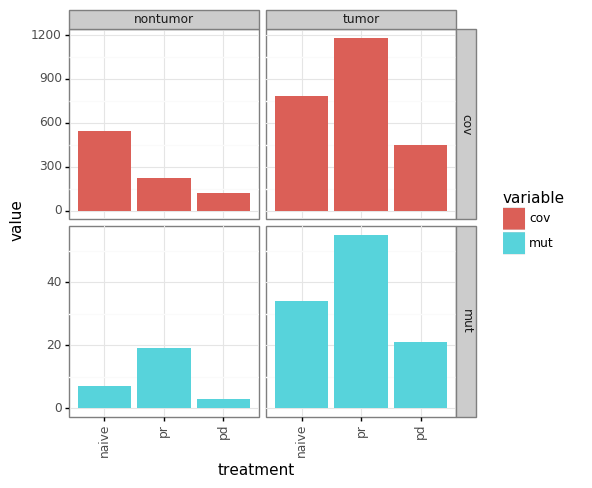

<ggplot: (-9223363251012125226)>


In [468]:
plotnine.options.figure_size = (5,5)
plot = (ggplot(pd.melt(mut_count_df, id_vars=['type_treatment','sum_cov','type','treatment']))
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90),
                aspect_ratio = 1
               )
        + geom_bar(aes('treatment','value',fill = 'variable'), stat='identity')
        + facet_grid('variable~type', scales = 'free')
       )
print(plot)


In [371]:
# gene = df['index'].tolist()

# out = symbol2field(gene)
# output = [print(f'{idx}: ', 
#        x['query'],
#        '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
#                                                                 x['query'],
#                                                                 '\n','N/A') for idx, x in enumerate(out)]


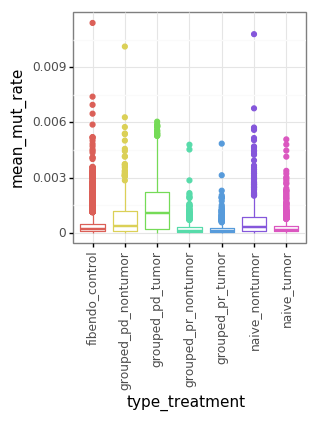

<ggplot: (-9223363255529508597)>


In [64]:
plotnine.options.figure_size = (3,3)
print(ggplot(norm_muts_df)
      + theme_bw()
      + theme(axis_text_x = element_text(angle = 90),
             legend_position = 'none')
      + geom_boxplot(aes('type_treatment','mean_mut_rate', color = 'type_treatment'))
     )

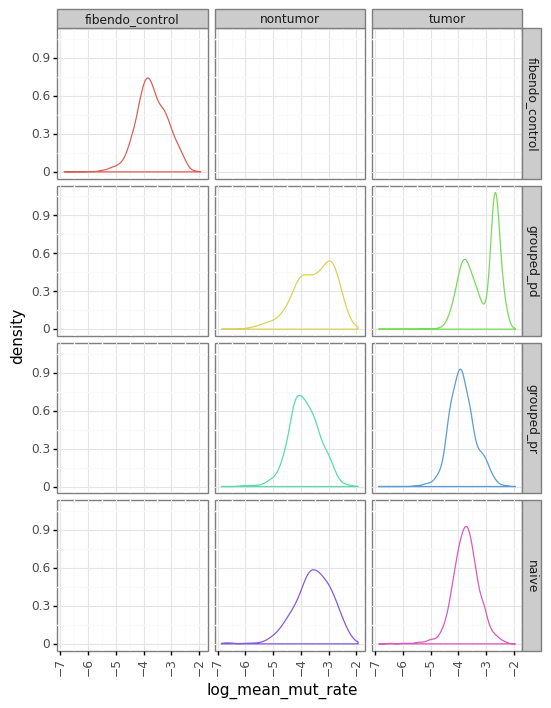

<ggplot: (8781328672730)>


In [65]:
plotnine.options.figure_size = (6,6)
print(ggplot(norm_muts_df)
      + theme_bw()
      + theme(aspect_ratio = 1,
              legend_position = 'none'
             )
      + theme(axis_text_x = element_text(angle = 90))
      + geom_density(aes('log_mean_mut_rate', color = 'type_treatment'))
      + facet_grid('analysis~inferCNV_annotation')
     )

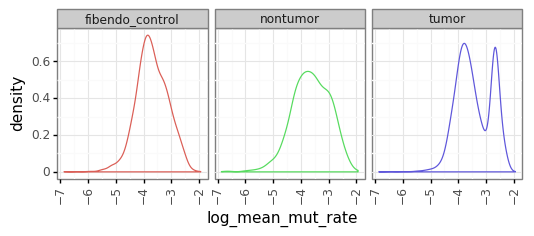

<ggplot: (-9223363255528577066)>


In [16]:
plotnine.options.figure_size = (6,6)
print(ggplot(norm_muts_df)
      + theme_bw()
      + theme(aspect_ratio = 1,
              legend_position = 'none'
             )
      + theme(axis_text_x = element_text(angle = 90))
      + geom_density(aes('log_mean_mut_rate', color = 'inferCNV_annotation'))
      + facet_wrap('~inferCNV_annotation')
     )


In [72]:
# see where verified driver cells are in distribution
mut_key = pd.read_csv('s3://daniel.le-work/test/mut_key.csv', index_col=0)
norm_muts_df['driver'] = [x in mut_key.cell.tolist() for x in norm_muts_df['index']]



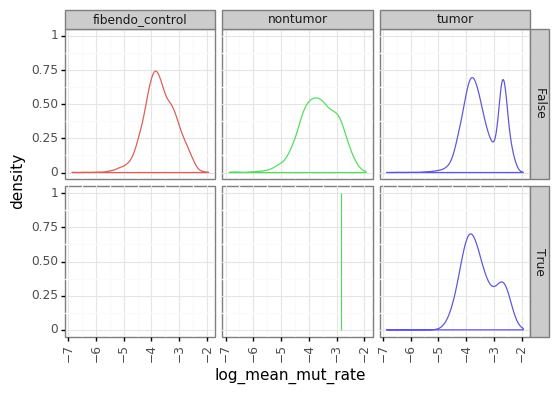

<ggplot: (8781324390548)>


In [73]:
plotnine.options.figure_size = (6,6)
print(ggplot(norm_muts_df)
      + theme_bw()
      + theme(aspect_ratio = 1,
              legend_position = 'none'
             )
      + theme(axis_text_x = element_text(angle = 90))
      + geom_density(aes('log_mean_mut_rate', color = 'inferCNV_annotation'))
      + facet_grid('driver~inferCNV_annotation')
     )


In [74]:
refy = 'grouped_pd_tumor'

input_df = norm_muts_df
input_df = input_df[input_df.type_treatment == refy].replace([-np.inf,np.inf],np.nan).dropna()
X = input_df.loc[:,['log_mean_mut_rate']].as_matrix()


In [75]:
gmm = GaussianMixture(n_components = 2)
gmm = gmm.fit(X=X)

gmm_x = np.linspace(-6,-1,100)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

mu1 = gmm.means_[0,0]
mu2 = gmm.means_[1,0]
sigma1 = gmm.covariances_[0,0][0]**0.5
sigma2 = gmm.covariances_[1,0][0]**0.5

gmm_df = pd.DataFrame({'gmm_x':gmm_x,
                       'gmm_y':gmm_y})

print(mu1, sigma1, mu2, sigma2)

-2.633800216520803 0.1408768335661121 -3.706008081097181 0.33822850129263726


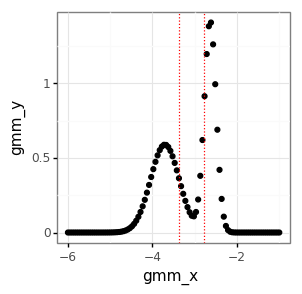

<ggplot: (8781325831414)>


In [76]:
plotnine.options.figure_size = (3,3)
print(ggplot(gmm_df)
      + theme_bw()
      + geom_point(aes('gmm_x','gmm_y'))
      + geom_vline(aes(xintercept = mu1-sigma1), color = 'red', linetype = ':')
      + geom_vline(aes(xintercept = mu2+sigma2), color = 'red', linetype = ':')
     )

In [77]:
# percent occupancy of hi,md,lo mutation rate in each group
norm_muts_df['mut_group'] = ['hi' if x > (mu1-sigma1) \
                             else 'lo' if x <= (mu2+sigma2) \
                             else 'md' for x in norm_muts_df['log_mean_mut_rate']]
norm_muts_df['mut_group'] = (norm_muts_df['mut_group']
                             .astype(str)
                             .astype(CategoricalDtype(['lo','md','hi'],ordered=True)))
norm_muts_df.head()


,index,mean_mut_rate,log_mean_mut_rate,analysis,inferCNV_annotation,type_treatment,sample_name,patient_id,driver,mut_group
0,A10_1001000407,0.003088,-2.510349,grouped_pd,tumor,grouped_pd_tumor,LT_S21,TH185,False,hi
1,A10_1001000408,0.004063,-2.391193,grouped_pd,tumor,grouped_pd_tumor,LT_S21,TH185,False,hi
2,A10_1001000412,0.003477,-2.458814,grouped_pd,tumor,grouped_pd_tumor,LT_S21,TH185,False,hi
3,A10_B000863,0.000005,-5.296862,grouped_pd,nontumor,grouped_pd_nontumor,LT_S47,TH220,False,lo
4,A10_B001470,0.000478,-3.320697,naive,nontumor,naive_nontumor,LT_S74,TH248,False,md


In [78]:
prop_df = (norm_muts_df.groupby('type_treatment')['mut_group']
           .value_counts())
prop_df = (pd.DataFrame(prop_df)
             .rename(columns = {'mut_group':'count'})
             .reset_index())
prop_df['prop'] = (prop_df
                     .groupby('type_treatment')['count']
                     .apply(lambda x: x/np.sum(x))
                    ).tolist()
prop_df['mut_group'] = (prop_df['mut_group']
                             .astype(str)
                             .astype(CategoricalDtype(['lo','md','hi'],ordered=True)))
prop_df['inferCNV'] = [x.split('_')[-1] for x in prop_df['type_treatment']]
prop_df['analysis'] = [x.split(f'_{y}')[0] for x,y in zip(prop_df['type_treatment'], prop_df['inferCNV'])]


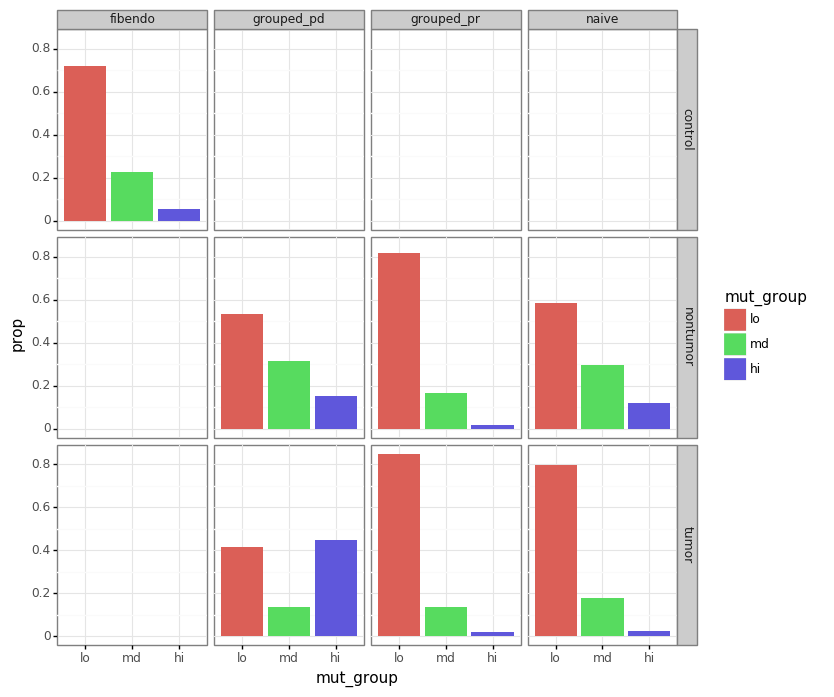

<ggplot: (8781325818709)>


In [79]:
plotnine.options.figure_size = (8,8)
print(ggplot(prop_df)
      + theme_bw()
      + geom_bar(aes('mut_group','prop',fill = 'mut_group'), stat='identity')
      + facet_grid('inferCNV~analysis')
     )


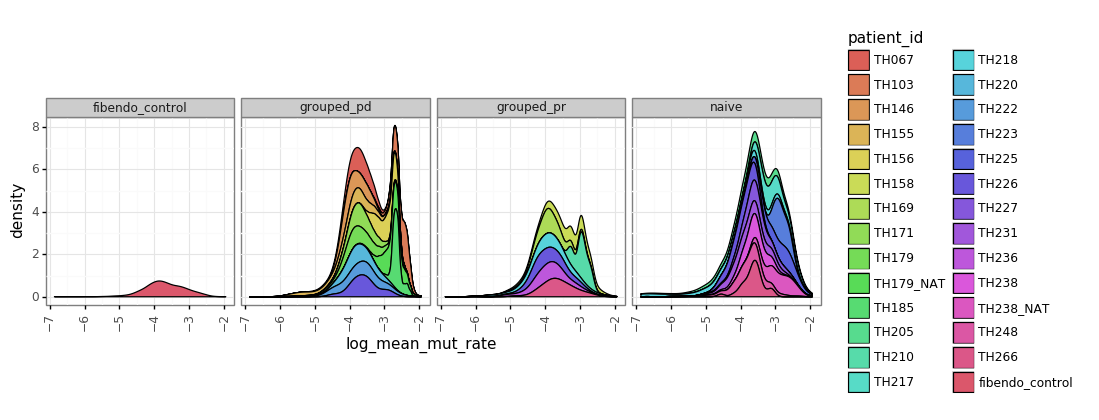

<ggplot: (-9223363255523038997)>


In [104]:
# check sample/patient sub distributions
plotnine.options.figure_size = (10,10)
print(ggplot(norm_muts_df)
      + theme_bw()
      + theme(aspect_ratio = 1,
#               legend_position = 'none'
             )
      + theme(axis_text_x = element_text(angle = 90))
      + geom_density(aes('log_mean_mut_rate', fill = 'patient_id'), position = position_stack())
      + facet_grid('.~analysis')
     )

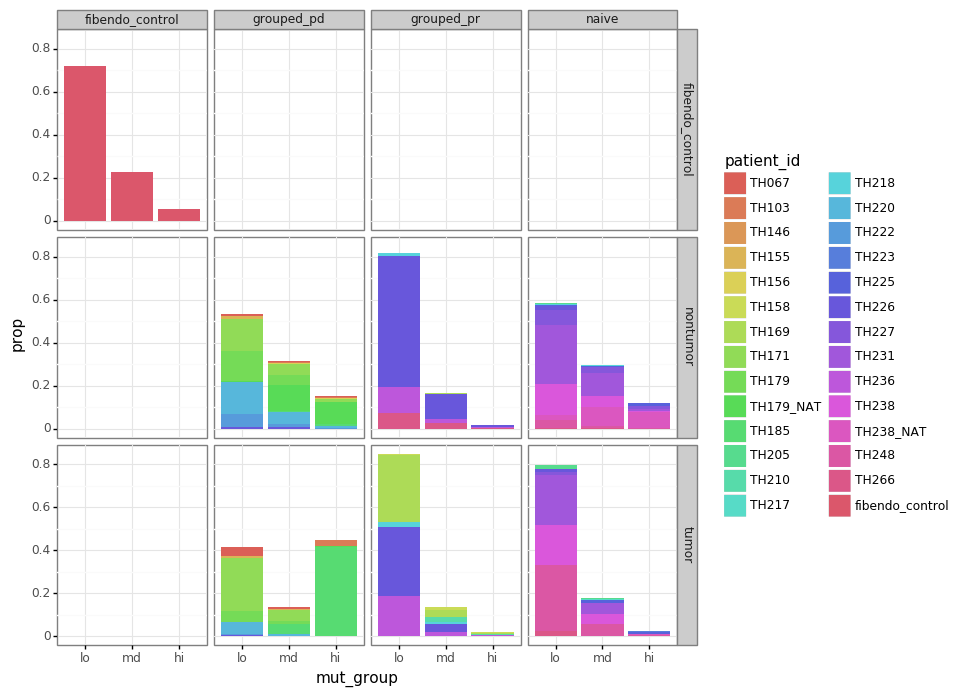

<ggplot: (-9223363255526576219)>


In [90]:
target = 'patient_id'
sample_prop_df = (norm_muts_df.groupby(['analysis','inferCNV_annotation','mut_group'])[target]
                    .value_counts())
sample_prop_df = (pd.DataFrame(sample_prop_df)
                    .rename(columns = {target:'count'})
                    .reset_index())
sample_prop_df['prop'] = (sample_prop_df
                         .groupby(['analysis','inferCNV_annotation'])['count']
                         .apply(lambda x: x/np.sum(x))
                        ).tolist()

plotnine.options.figure_size = (8,8)
print(ggplot(sample_prop_df)
      + theme_bw()
      + geom_bar(aes('mut_group','prop',fill = target), stat='identity')
      + facet_grid('inferCNV_annotation~analysis')
     )


In [89]:
sample_prop_df


,analysis,inferCNV_annotation,mut_group,patient_id,count,prop
0,fibendo_control,fibendo_control,lo,fibendo_control,2536,1.000000
1,fibendo_control,fibendo_control,md,fibendo_control,796,1.000000
2,fibendo_control,fibendo_control,hi,fibendo_control,195,1.000000
3,grouped_pd,nontumor,lo,TH220,73,0.280769
4,grouped_pd,nontumor,lo,TH171,72,0.276923
5,grouped_pd,nontumor,lo,TH179,68,0.261538
6,grouped_pd,nontumor,lo,TH222,29,0.111538
7,grouped_pd,nontumor,lo,TH155,7,0.026923
8,grouped_pd,nontumor,lo,TH067,6,0.023077
9,grouped_pd,nontumor,lo,TH226,3,0.011538
